In [8]:
import sys
sys.path.insert(1, 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\impedance.py') #\\impedance')
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from impedance.circuits import CustomCircuit
from impedance.plotting_BG import plot_nyquist
from impedance import preprocessing

from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy import optimize

import ImpedanceCorrection as IC
import IC_plotting
%reload_ext autoreload
%autoreload 2

In [2]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

f_name=all_files[1]
print(f_name)
f0, Z0= preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par


Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
 active_mask: array([0., 0.])
        cost: 0.32381278982558276
         fun: array([0.80475187])
        grad: array([ 0.        , 47.05544463])
         jac: array([[ 0.        , 58.47199133]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 40
        njev: 13
  optimality: 47.055444630707385
      status: 3
     success: True
           x: array([2.00000000e+03, 3.40300939e-04])
 active_mask: array([0, 0])
        cost: 0.32381278982558276
         fun: array([0.80475187])
        grad: array([ 0.        , 47.05544463])
         jac: array([[ 0.        , 58.47199133]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 17
        njev: 1
  optimality: 0.015965956555186952
      status: 3
     success: True
           x: array([2.00000000e+03, 3.40300939e-04])


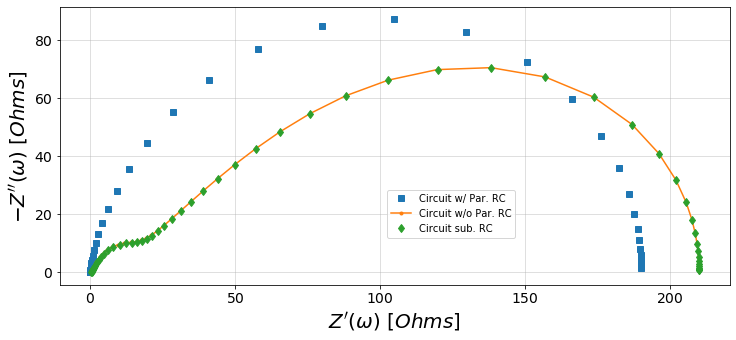

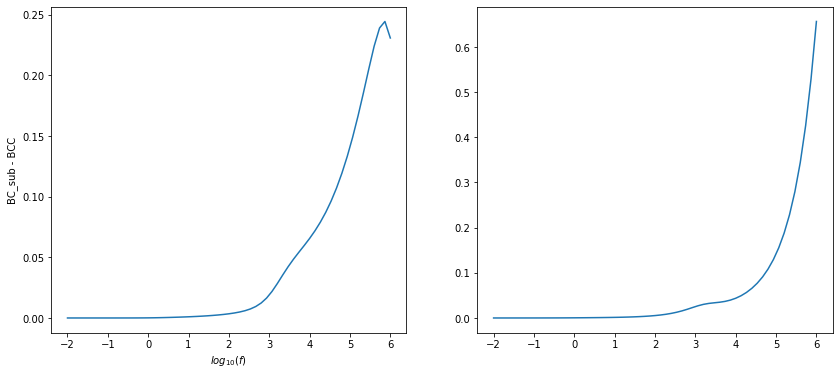

In [3]:
circ = 'p(R1, C1,p(R2,C2)-G1)'
circCorr = 'p(R2,C2)-G1'

vals = [2000, 3.4e-4, 10, 1e-5, 200, .1]
valsCorr = [10, 1e-5, 200, .1]


pred_freq = np.logspace(np.log10(1e6), np.log10(1e-2), num = f0.size)

BertCirc = CustomCircuit(circ, initial_guess = vals)
BC_pred = BertCirc.predict(pred_freq)

BertCircCorr = CustomCircuit(circCorr, initial_guess = valsCorr)
BCC_pred = BertCircCorr.predict(pred_freq)

RC0 = np.array([2e3, 1e-4])
d_st = 3e-16
x_t = xtol=3e-16
f_t = ftol=3e-16
g_t = gtol=3e-16


resRC= least_squares(IC.Par_RC_Res, RC0, method= 'trf', args=(pred_freq, BC_pred), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)
print(resRC)
resRC= least_squares(IC.Par_RC_Res, resRC.x, method= 'trf', args=(pred_freq, BC_pred), bounds=[(1e3, 1e-6), (1e4, 1e-3)] , max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)
print(resRC)

LS_only = IC.par_RC_subtract(resRC.x, pred_freq, BC_pred)

fig, ax0 = plt.subplots(figsize=(12,12))
plot_nyquist(ax0, BC_pred,fmt='s', label='Circuit w/ Par. RC')
plot_nyquist(ax0, BCC_pred, label='Circuit w/o Par. RC')
plot_nyquist(ax0, LS_only, fmt='d', label='Circuit sub. RC')
fig.legend(loc=(0.525,.3))
# fig.savefig('Figures\Corrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig2, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,6))
ax1.plot(np.log10(pred_freq), np.real((LS_only-BCC_pred)/BCC_pred))
ax1.set_ylabel('BC_sub - BCC')
ax1.set_xlabel('$log_{10}(f)$')
# fig.savefig('Figures\Correction_Error.png', dpi=300, bbox_inches='tight')

ax2.plot(np.log10(pred_freq), np.imag((LS_only-BCC_pred)/BCC_pred))

plt.show()

# fig.savefig('Figures\Berthier Correction\Parallel RC Simulated Data.svg', dpi=300, bbox_inches='tight')

In [4]:
rrange = ((1e3, 1e4), (1e-4,1e-3))

bruteout100 = brute(IC.Par_RC_Res, rrange, Ns=100, args=(pred_freq, BC_pred), full_output=True)

resRCout = least_squares(IC.Par_RC_Res, bruteout100[0], method= 'trf', loss='soft_l1', args=(pred_freq, BC_pred), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)

Bru100_only = IC.par_RC_subtract(bruteout100[0], pred_freq, BC_pred)
LS_Bru100 = IC.par_RC_subtract(resRCout.x, pred_freq, BC_pred)

print(resRC, '\n', bruteout100[0],'\n', resRCout)

 active_mask: array([0, 0])
        cost: 0.32381278982558276
         fun: array([0.80475187])
        grad: array([ 0.        , 47.05544463])
         jac: array([[ 0.        , 58.47199133]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 17
        njev: 1
  optimality: 0.015965956555186952
      status: 3
     success: True
           x: array([2.00000000e+03, 3.40300939e-04]) 
 [1.18320906e+03 3.40300940e-04] 
  active_mask: array([0., 0.])
        cost: 0.2835986832533981
         fun: array([0.80475187])
        grad: array([ 0.        , 32.25063958])
         jac: array([[ 0.        , 35.37216998]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 28
        njev: 1
  optimality: 32.25063958406684
      status: 3
     success: True
           x: array([1.18320906e+03, 3.40300940e-04])


In [5]:
Yel = 1/BC_pred
RC = [-4, 8.2e-4]

w = IC.calcw(pred_freq)
Y = Yel - (1 / 10**RC[0]) #- RC[1] * (1j * w)


a = np.diff(Y)
b = np.diff(np.conj(Y))

s = np.real(np.sum(a*b))

LY = np.sqrt(s)

print(s, np.sum(a*b), np.sum(a), np.sum(b))
# print(np.real(np.sum(a*b)), '\n', a)

696335.0598295329 (696335.0598295329+0j) (-2.5588776499644155-2139.0748997409146j) (-2.5588776499644155+2139.0748997409146j)


In [6]:
subRs = np.logspace(3, 4, num=8)
ReaalC = 3.4e-4

corrs = []

for Rs in subRs:
    corrs.append(IC.par_RC_subtract([Rs, ReaalC], pred_freq, BC_pred))
    
BC_sub = IC.par_RC_subtract([1.995e3, ReaalC], pred_freq, BC_pred)
subRs

array([ 1000.        ,  1389.49549437,  1930.69772888,  2682.69579528,
        3727.59372031,  5179.47467923,  7196.85673001, 10000.        ])

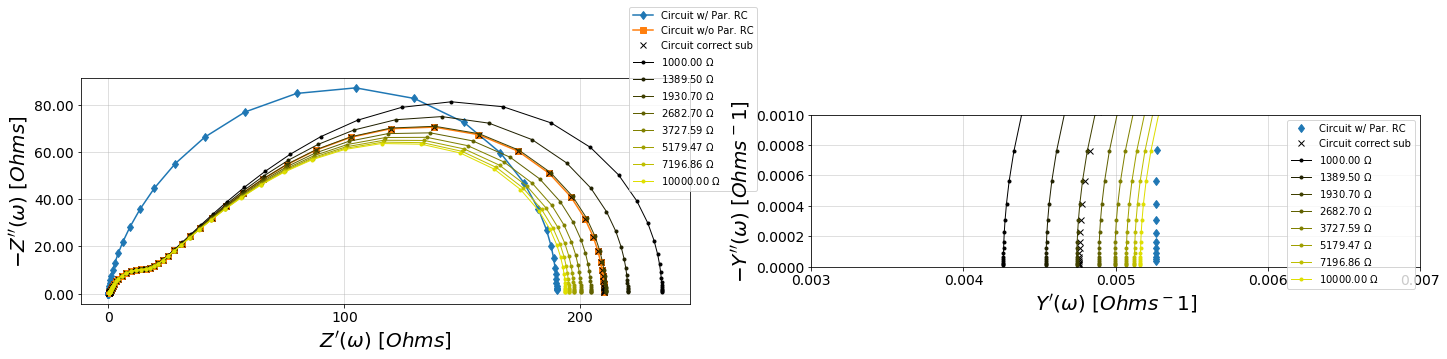

In [9]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(24,6))
plot_nyquist(ax0, BC_pred, fmt='-d', label='Circuit w/ Par. RC')
plot_nyquist(ax0, BCC_pred, fmt='-s', label='Circuit w/o Par. RC')
plot_nyquist(ax0, BC_sub, fmt='x', label='Circuit correct sub', c=(0,0,0))

Y_BC = 1/BC_pred
Y_BCC = 1/BCC_pred
Y_BCsub = 1/BC_sub


IC_plotting.plot_admittance(ax1, Y_BC, fmt='d', label='Circuit w/ Par. RC')
IC_plotting.plot_admittance(ax1, Y_BCsub, fmt='x', label='Circuit correct sub', c=(0,0,0))

for n in range(len(corrs)):
    data = corrs[n]
    Y_corrs = 1/data
    plot_nyquist(ax0, data, fmt='.-', lw=1, label='%.2f $\Omega$' % subRs[n], c=(n/len(corrs),n/len(corrs),0))
    IC_plotting.plot_admittance(ax1, Y_corrs[:], fmt= '.-', lw=1, label='%.2f $\Omega$' % subRs[n], c=(n/len(corrs),n/len(corrs),0))


ax1.set_ylim(0,.001)
ax1.set_xlim(3e-3,7e-3)

ax0.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax0.legend(loc=(0.9,.5))
ax1.legend()

# fig.savefig('Figures\Berthier Correction\Parallel RC Simulated Data Fitting.svg', dpi=300, bbox_inches='tight')

In [10]:
rrange = ((2, 4), (-5,-3))
bruteout10 = brute(IC.Par_RC_Res_log, rrange, Ns=3, args=(pred_freq, BC_pred), full_output=True)

duma = bruteout10[2]
man_brute=[]
prams=[]

for i in range(duma.shape[1]):
    for j in range(duma.shape[2]):
        prams.append(duma[:,i,j])
        man_brute.append(IC.par_RC_subtract_log(duma[:,i,j], pred_freq, BC_pred))
        
prams = np.array(prams)
man_brute = np.array(man_brute)

ValueError: cannot reshape array of size 549 into shape (3,3)

In [11]:
syms = ['<-', '^-', '>-', 'v-', 'o-', '.-', '<--', '^--', '>--', 'v--']

Cmax = prams[len(prams)-1][0]
Rmax = prams[len(prams)-1][1]
pramlen = int(np.sqrt(len(prams)))

Y_BC = 1/BC_pred
Y_BCC = 1/BCC_pred
Y_BCsub = 1/BC_sub

# fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(24,6))
fig, ax0 = plt.subplots(figsize=(12, 12))


for n in range(len(man_brute)):
    data = man_brute[n]
    Y_corrs = 1/data
    plot_nyquist(ax0, data, fmt=syms[np.mod(n, pramlen)], lw=1, label=str(prams[n]), c=(n/len(prams), n/len(prams), 0))
#     IC_plotting.plot_admittance(ax1, Y_corrs[:], fmt= syms[np.mod(n, pramlen)], label=str(prams[n]), c=(n/len(prams), n/len(prams), 0))

plot_nyquist(ax0, BC_pred, fmt='-d', label='Circuit w/ Par. RC')
plot_nyquist(ax0, BCC_pred, fmt='-s', label='Circuit w/o Par. RC')

# ax1.plot(Y_BC[:].real, Y_BC[:].imag, '-d', label='Circuit w/ Par. RC')
# ax1.plot(Y_BCC[:].real, Y_BCC[:].imag, '-s', label='Circuit w/o Par. RC')

    
# ax1.set_ylim(0,.01)
# ax1.set_xlim(3e-3,2e-2)
ax0.legend(loc=(.95,0))
# ax1.legend()

plt.show()


NameError: name 'prams' is not defined

# Real Data

In [12]:
rrange = ((3.5,9.5), (-8,-4))
bruteout10 = brute(IC.Par_RC_Res_log, rrange, Ns=10, args=(freqs[1:], Z[1:]), full_output=True)

duma = bruteout10[2]
man_brute=[]
prams=[]

for i in range(duma.shape[1]):
    for j in range(duma.shape[2]):
#         print(duma[:,i,j])
        prams.append(duma[:,i,j])
        man_brute.append(IC.par_RC_subtract_log(duma[:,i,j], freqs[1:], Z[1:]))
        
prams = np.array(prams)
man_brute = np.array(man_brute)
mapped = set(zip(bruteout10[2][0,:,0], bruteout10[2][-1,0]))
print(mapped)

C:\Users\shadd\OneDrive\Documents\Python\EIS\ImpedanceCorrection.py:145: RuntimeWarning: invalid value encountered in sqrt
  LY = np.sqrt(S)   # + np.sum(np.angle(Yel))


ValueError: cannot reshape array of size 5800 into shape (10,10)

In [13]:
Cmax = prams[len(prams)-1][0]
Rmax = prams[len(prams)-1][1]
pramlen = int(np.sqrt(len(prams)))

Y = 1/Z[1:]

fig, ax0 = plt.subplots(figsize=(8,8))
fig2, ax1 = plt.subplots(figsize=(8,8))

for n in range(len(man_brute)):
    data = man_brute[n]
    Y_corrs = 1/data
#     if prams[n, 0] >= prams[0, 0]:
    plot_nyquist(ax0, data, fmt=syms[np.mod(n, pramlen)], lw=1, label=str(prams[n]), c=(n/len(prams)*.9, n/len(prams), n/len(prams)*.7))
    plot_nyquist(ax1, data, fmt=syms[np.mod(n, pramlen)], lw=1, label=str(prams[n]), c=(n/len(prams)*.9, n/len(prams), n/len(prams)*.7))
#     IC_plotting.plot_admittance(ax1, Y_corrs, fmt= syms[np.mod(n, pramlen)], lw=1, label=str(prams[n]), c=(n/len(prams)*.9, n/len(prams), n/len(prams)))

plot_nyquist(ax0, Z, fmt='-d', label='Initial')
IC_plotting.plot_admittance(ax1, Y, fmt='-d', label='Initial')

    
ax1.set_ylim(0,.01)
ax1.set_xlim(0,2e-2)
# ax0.legend(loc=(.6,0))
# ax0.set_xlim((0, 1000))
# ax0.set_ylim((0, 500))
# fig.legend(loc=(0.525,.3))
# fig.savefig('Figures\Berthier Correction\Parallel RC Real Data.png', dpi=300, bbox_inches='tight')
# ax0.set_xlim(-10,100)
# ax0.set_ylim(-30,80)
# fig.savefig('Figures\Berthier Correction\Parallel RC Real Data Zoom.png', dpi=300, bbox_inches='tight')


plt.show()

NameError: name 'prams' is not defined